In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
plt.rcParams['font.sans-serif'] = ['SimHei']        # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    

df = pd.read_csv("C:/Users/Administrator/Desktop/交通数据_两个月.csv", encoding="gbk")
start_date = pd.to_datetime("2021-7-10")
time_list = pd.date_range(start=start_date, periods=len(df), freq="15min")
df["datetime"] = time_list
df = df.set_index('datetime').drop(["时间", "日期",'星期几'], axis=1).reset_index()
df["hour"] = df["datetime"].dt.hour

# 提取星期几（0=周一，6=周日）
df["weekday"] = df["datetime"].dt.weekday

# 判断是否为周末
df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x > 5 else 0)
df["is_weekend"] = df["is_weekend"].astype(int)
df.head


<bound method NDFrame.head of                 datetime  小汽车数量  自行车数量  公交车数量  卡车数量  总车辆数量    交通状况  hour  \
0    2021-07-10 00:00:00     13      2      2    24     41  normal     0   
1    2021-07-10 00:15:00     14      1      1    36     52  normal     0   
2    2021-07-10 00:30:00     10      2      2    32     46  normal     0   
3    2021-07-10 00:45:00     10      2      2    36     50  normal     0   
4    2021-07-10 01:00:00     11      2      1    34     48  normal     1   
...                  ...    ...    ...    ...   ...    ...     ...   ...   
5947 2021-09-09 22:45:00     16      3      1    36     56  normal    22   
5948 2021-09-09 23:00:00     11      0      1    30     42  normal    23   
5949 2021-09-09 23:15:00     15      4      1    25     45  normal    23   
5950 2021-09-09 23:30:00     16      5      0    27     48  normal    23   
5951 2021-09-09 23:45:00     14      3      1    15     33     low    23   

      weekday  is_weekend  
0           5           0  
1

In [2]:
#df.to_csv("交通数据_两个月_含时间字段.csv", index=False, encoding='utf-8-sig')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 特征和目标
# 手动映射交通状态为数字编码
status_map = {
    'heavy': 0,
    'high': 1,
    'low': 2 ,
    'normal' : 3   
}
df['交通状况'] = df['交通状况'].map(status_map)

features = ['hour', 'weekday', '小汽车数量', '卡车数量', '公交车数量','自行车数量','is_weekend']  
X = df[features]
y = df['交通状况']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 构建随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
# 预测
y_pred = rf_model.predict(X_test)

# 输出评估结果
print("准确率：", accuracy_score(y_test, y_pred))
print("\n混淆矩阵：\n", confusion_matrix(y_test, y_pred))
print("\n分类报告：\n", classification_report(y_test, y_pred))


准确率： 0.9739714525608733

混淆矩阵：
 [[207   4   0   5]
 [  3  68   0  10]
 [  0   0 142   4]
 [  4   1   0 743]]

分类报告：
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       216
           1       0.93      0.84      0.88        81
           2       1.00      0.97      0.99       146
           3       0.98      0.99      0.98       748

    accuracy                           0.97      1191
   macro avg       0.97      0.94      0.95      1191
weighted avg       0.97      0.97      0.97      1191



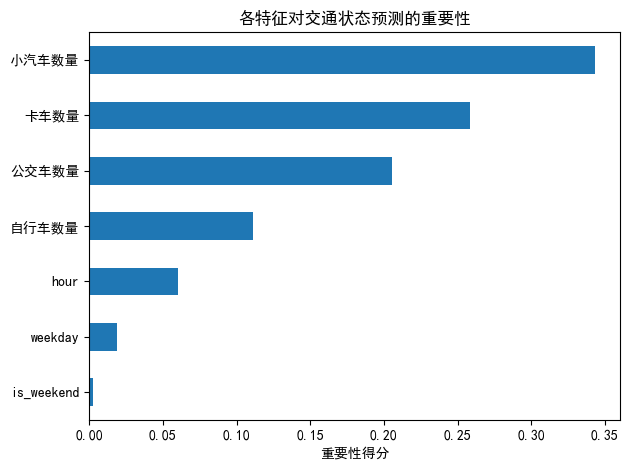

In [4]:

importances = pd.Series(rf_model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title("各特征对交通状态预测的重要性")
plt.xlabel("重要性得分")
plt.tight_layout()
plt.show()


In [5]:
smooth_df = df[df['交通状况'] == 3]  # 只保留通畅状态
vehicle_cols = ['小汽车数量', '卡车数量', '公交车数量','自行车数量']
data = smooth_df[['hour'] + vehicle_cols]
data

,hour,小汽车数量,卡车数量,公交车数量,自行车数量
0,0,13,24,2,2
1,0,14,36,1,1
2,0,10,32,2,2
3,0,10,36,2,2
4,1,11,34,1,2
...,...,...,...,...,...
5946,22,11,23,0,4
5947,22,16,36,1,3
5948,23,11,30,1,0
5949,23,15,25,1,4


In [6]:
avg_structure = data[vehicle_cols].mean()
avg_structure

小汽车数量    48.249030
卡车数量     23.050970
公交车数量     8.846814
自行车数量     8.372853
dtype: float64

In [7]:
grouped = data.groupby('hour')[vehicle_cols].mean()
print(grouped.head())


          小汽车数量       卡车数量     公交车数量     自行车数量
hour                                          
0     12.160194  29.893204  0.757282  1.650485
1     11.869347  29.909548  0.824121  1.633166
2     12.139423  30.697115  0.802885  1.528846
3     12.206573  30.046948  0.816901  1.680751
4     72.227586  21.317241  3.979310  8.827586


In [8]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans


cluster_result = []

# 4. 遍历每个小时段（0~23）
for hour in range(24):
    hour_data = smooth_df[smooth_df['hour'] == hour][vehicle_cols]
    
    if len(hour_data) < 3:  # 如果数据太少就跳过该小时
        continue

 # 5. 对该小时内的数据进行 KMeans 聚类（比如分2类）
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(hour_data)

    # 6. 将聚类中心添加进结果列表
    centers = kmeans.cluster_centers_
    for i, center in enumerate(centers):
        cluster_result.append({
            'hour': hour,
            'cluster': i,
            '小汽车数量': center[0],
            '卡车数量': center[1],
            '公交车数量': center[2],
            '自行车数量': center[3]
        })
cluster_df = pd.DataFrame(cluster_result)
cluster_df

,hour,cluster,小汽车数量,卡车数量,公交车数量,自行车数量
0,0,0,12.010417,35.416667,0.812500,1.520833
1,0,1,12.290909,25.072727,0.709091,1.763636
2,1,0,11.359223,34.864078,0.834951,1.466019
3,1,1,12.416667,24.593750,0.812500,1.812500
4,2,0,11.315789,35.666667,0.868421,1.289474
5,2,1,13.138298,24.670213,0.723404,1.819149
6,3,0,8.941667,29.725000,0.966667,1.241667
7,3,1,16.419355,30.462366,0.623656,2.247312
8,4,0,87.311321,17.783019,4.773585,11.037736
9,4,1,31.230769,30.923077,1.820513,2.820513


In [42]:
# 对于每小时，只保留样本最多的那一个聚类中心
best_centers = []

for hour in range(24):
    subset = cluster_df[cluster_df['hour'] == hour]
    if subset.empty:
        continue

    # 加载这个小时的真实聚类数量数据
    label_counts = pd.Series(
        smooth_df[smooth_df['hour'] == hour]
        .pipe(lambda df: KMeans(n_clusters=2, random_state=42)
              .fit_predict(df[vehicle_cols]))
    ).value_counts()

    # 找出最大类
    dominant_cluster = label_counts.idxmax()
    best_center = subset[subset['cluster'] == dominant_cluster]
    best_centers.append(best_center)

# 合并成新的 DataFrame
best_center_df = pd.concat(best_centers, ignore_index=True)
best_center_df

,hour,cluster,小汽车数量,卡车数量,公交车数量,自行车数量
0,0,1,12.290909,25.072727,0.709091,1.763636
1,1,0,11.359223,34.864078,0.834951,1.466019
2,2,0,11.315789,35.666667,0.868421,1.289474
3,3,0,8.941667,29.725000,0.966667,1.241667
4,4,0,87.311321,17.783019,4.773585,11.037736
5,5,1,97.680851,12.819149,7.500000,14.765957
6,6,0,99.726027,9.246575,17.876712,19.438356
7,7,0,101.269231,8.935897,18.615385,19.012821
8,8,0,100.781250,8.375000,18.484375,19.625000
9,9,1,78.935484,14.983871,17.370968,11.500000


In [65]:


limits = {}  # 用于保存每种车型的推荐通行上限

for col in vehicle_cols:
    Q1 = smooth_df[col].quantile(0.25)
    Q3 = smooth_df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR  # 最大推荐值
    limits[col] = {
        'Q1': round(Q1, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'MaxRecommended': round(upper_bound, 2)
    }


limits_df = pd.DataFrame(limits).T
print(limits_df)


         Q1    Q3   IQR  MaxRecommended
小汽车数量  14.0  80.0  66.0           179.0
卡车数量   16.0  30.0  14.0            51.0
公交车数量   1.0  15.0  14.0            36.0
自行车数量   2.0  14.0  12.0            32.0


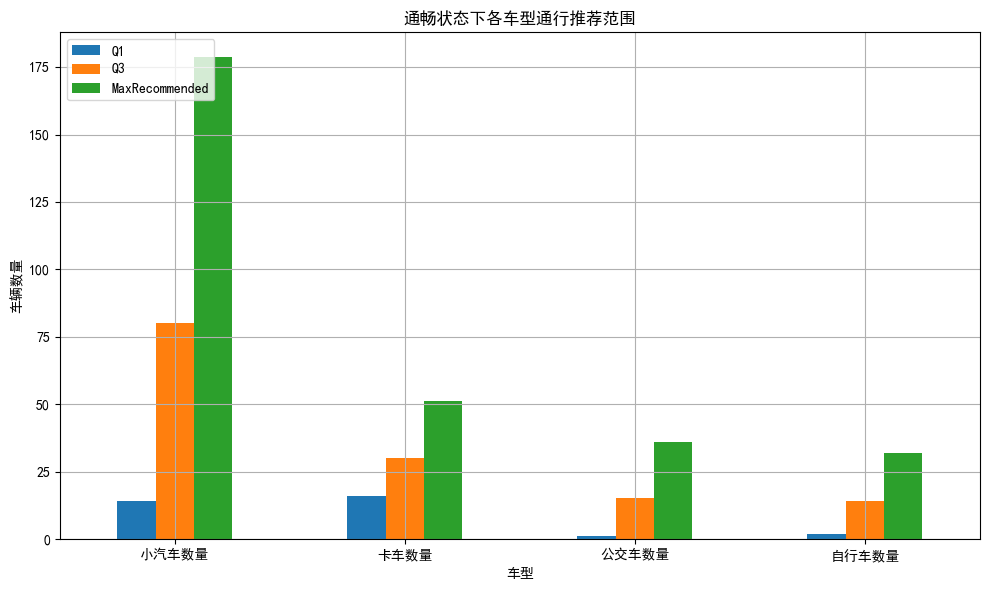

In [66]:
limits_df[['Q1', 'Q3', 'MaxRecommended']].plot(kind='bar', figsize=(10,6))
plt.title('通畅状态下各车型通行推荐范围')
plt.ylabel('车辆数量')
plt.xlabel('车型')
plt.xticks(rotation=0)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()